### Homework 5: Question search engine

Remeber week01 where you used GloVe embeddings to find related questions? That was.. cute, but far from state of the art. It's time to really solve this task using context-aware embeddings.

__Warning:__ this task assumes you have seen `seminar.ipynb`!

In [1]:
%pip install --upgrade transformers datasets accelerate deepspeed sentencepiece
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import datasets
from transformers import get_linear_schedule_with_warmup, get_scheduler
from transformers import AdamW

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 836.6/836.6 kB 46.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 6.9 MB/s eta 0:00

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
from IPython.display import clear_output
import pickle
from datasets import Dataset

### Load data and model

In [3]:
qqp = datasets.load_dataset('SetFit/qqp')
print('\n')
print("Sample[0]:", qqp['train'][0])
print("Sample[3]:", qqp['train'][3])

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/SetFit___json/SetFit--qqp-f6f819660b0aea78/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]



Sample[0]: {'text1': 'How is the life of a math student? Could you describe your own experiences?', 'text2': 'Which level of prepration is enough for the exam jlpt5?', 'label': 0, 'idx': 0, 'label_text': 'not duplicate'}
Sample[3]: {'text1': 'What can one do after MBBS?', 'text2': 'What do i do after my MBBS ?', 'label': 1, 'idx': 3, 'label_text': 'duplicate'}


In [ ]:
len(qqp['train'])

363846

In [4]:
if torch.cuda.is_available():
    device = torch.device(f'cuda:0')
else:
    device = torch.device('cpu')

In [6]:
device

device(type='cuda', index=0)

In [5]:
model_name = "gchhablani/bert-base-cased-finetuned-qqp"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

[2023-07-20 10:23:29,863] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


### Tokenize the data

In [7]:
MAX_LENGTH = 128
def preprocess_function(examples):
    result = tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH, truncation=True
    )
    result['label'] = examples['label']
    return result

qqp_preprocessed = qqp.map(preprocess_function, batched=True)

Map:   0%|          | 0/363846 [00:00<?, ? examples/s]

Map:   0%|          | 0/40430 [00:00<?, ? examples/s]

Map:   0%|          | 0/390965 [00:00<?, ? examples/s]

In [ ]:
print(repr(qqp_preprocessed['train'][0]['input_ids'])[:100], "...")

[101, 1731, 1110, 1103, 1297, 1104, 170, 12523, 2377, 136, 7426, 1128, 5594, 1240, 1319, 5758, 136,  ...


In [ ]:
qqp_preprocessed.keys()

dict_keys(['train', 'validation', 'test'])

### Task 1: evaluation (1 points)

We randomly chose a model trained on QQP - but is it any good?

One way to measure this is with validation accuracy - which is what you will implement next.

Here's the interface to help you do that:

In [ ]:
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=128, shuffle=False, collate_fn=transformers.default_data_collator, num_workers=2
)

In [ ]:
for batch in val_loader:
     break  # here be your training code
print("Sample batch:", batch)

with torch.no_grad():
  predicted = model(
      input_ids=batch['input_ids'].to(device),
      attention_mask=batch['attention_mask'].to(device),
      token_type_ids=batch['token_type_ids'].to(device)
  )
probs = torch.softmax(predicted.logits, dim=1).data.cpu().numpy()
print('\nPrediction (probs):', probs)
print(np.argmax(probs, axis = 1))
print( batch['labels'].data.cpu().numpy())
print(sum(batch['labels'].data.cpu().numpy() == np.argmax(probs, axis = 1)))

Sample batch: {'labels': tensor([0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 1]), 'idx': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95

__Your task__ is to measure the validation accuracy of your model.
Doing so naively may take several hours. Please make sure you use the following optimizations:

- run the model on GPU with no_grad
- using batch size larger than 1
- use optimize data loader with num_workers > 1
- (optional) use [mixed precision](https://pytorch.org/docs/stable/notes/amp_examples.html)


In [ ]:
correct_responses, total_examples = 0, 0
for batch in tqdm(val_loader):
    with torch.no_grad():
        predicted = model(
           input_ids=batch['input_ids'].to(device),
           attention_mask=batch['attention_mask'].to(device),
           token_type_ids=batch['token_type_ids'].to(device)
       )
        real_labels = batch['labels'].data.cpu().numpy()
        probs = torch.softmax(predicted.logits, dim=1).data.cpu().numpy()
        predicted_labels = np.argmax(probs, axis = 1)
        correct_responses += sum(real_labels == predicted_labels)
        total_examples += real_labels.shape[0]



accuracy = correct_responses / total_examples


100%|██████████| 316/316 [04:22<00:00,  1.20it/s]


In [ ]:
accuracy

0.9083848627256987

In [ ]:
assert 0.9 < accuracy < 0.91

### Task 2: train the model (5 points)

For this task, you have two options:

__Option A:__ fine-tune your own model. You are free to choose any model __except for the original BERT.__ We recommend [DeBERTa-v3](https://huggingface.co/microsoft/deberta-v3-base). Better yet, choose the best model based on public benchmarks (e.g. [GLUE](https://gluebenchmark.com/)).

You can write the training code manually or use transformers.Trainer (see [this example](https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification)). Please make sure that your model's accuracy is at least __comparable__ with the above example for BERT.


__Option B:__ compare at least 3 pre-finetuned models (in addition to the above BERT model). For each model, report (1) its accuracy, (2) its speed, measured in samples per second in your hardware setup and (3) its size in megabytes. Please take care to compare models in equal setting, e.g. same CPU / GPU. Compile your results into a table and write a short (~half-page on top of a table) report, summarizing your findings.

In [8]:
from transformers.models.deberta_v2 import DebertaV2TokenizerFast

In [9]:
model_name = "microsoft/deberta-v3-base"
deberta_tokenizer = DebertaV2TokenizerFast.from_pretrained(model_name)
deberta_model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['pooler.dense.weight', 'classifier.bias', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
qqp

DatasetDict({
    train: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text'],
        num_rows: 363846
    })
    validation: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text'],
        num_rows: 40430
    })
    test: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text'],
        num_rows: 390965
    })
})

In [10]:
MAX_LENGTH = 128
def preprocess_function(examples, tokenizer):
    result = tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH,
        truncation=True
    )
    result['label'] = examples['label']
    return result

In [11]:
deberta_preprocess = partial(preprocess_function, tokenizer = deberta_tokenizer)

In [12]:
qqp_preprocessed_for_deberta = qqp.map(deberta_preprocess, batched=True)

Map:   0%|          | 0/363846 [00:00<?, ? examples/s]

Map:   0%|          | 0/40430 [00:00<?, ? examples/s]

Map:   0%|          | 0/390965 [00:00<?, ? examples/s]

In [13]:
questions = set(qqp['train']['text1'] + qqp['train']['text2'])

In [ ]:
list(questions)[:10]

['PAN Card: I lost my Aadhaar card. How can I get a second copy?',
 'How can I stay away from loneliness?',
 'What is dark internet, how does it work, is it safe, how can I access it?',
 'What industries/businesses require a product catalog?',
 'Do diffusion and osmosis require energy to occur? Why?',
 'What is the best: dual-core, qua-core or octa-core?',
 'How many animals are in this picture?',
 'What is a good topic for undergraduate math research?',
 'How would you turn 200K into 1 Million?',
 'Why is Jill Stein running for president if she has little to no chance of winning?']

In [ ]:
qqp_preprocessed_for_deberta['train']

Dataset({
    features: ['text1', 'text2', 'label', 'idx', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 363846
})

In [ ]:
qqp_preprocessed_for_deberta

DatasetDict({
    train: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 363846
    })
    validation: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 40430
    })
    test: Dataset({
        features: ['text1', 'text2', 'label', 'idx', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 390965
    })
})

In [ ]:
qqp_preprocessed_for_deberta['train']

Dataset({
    features: ['text1', 'text2', 'label', 'idx', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 363846
})

In [ ]:
type(qqp_preprocessed_for_deberta['train'])

datasets.arrow_dataset.Dataset

In [14]:
train_set = qqp_preprocessed_for_deberta['train']
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=16, shuffle=True, collate_fn=transformers.default_data_collator, num_workers=2
)

val_set = qqp_preprocessed_for_deberta['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=16, shuffle=True, collate_fn=transformers.default_data_collator, num_workers=2
)

In [15]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [30]:
def val_epoch(model, criterion, loader):
    model.eval()
    number_of_iters = len(loader)
    running_loss = 0.0
    accuracy, num_of_samples = 0, 0

    with torch.no_grad():
        for batch in tqdm(loader):
            pred = model(input_ids=batch['input_ids'].to(device),
                     attention_mask=batch['attention_mask'].to(device),
                     token_type_ids=batch['token_type_ids'].to(device))
            loss = criterion(pred.logits, batch['labels'].to(device))
            running_loss += loss.item()
            probs = torch.softmax(pred.logits, dim=1).data.cpu().numpy()
            predicted_labels = np.argmax(probs, axis = 1)
            real_labels = batch['labels'].data.cpu().numpy()
            accuracy += sum(real_labels == predicted_labels)
            num_of_samples += len(real_labels)

        running_loss /= number_of_iters
        accuracy /= num_of_samples
    return running_loss, accuracy

In [35]:
def train_epoch(model, optimizer, criterion, loader, val_loader, scheduler, metrics):
    model.train()
    criterion.to(device)
    running_loss = 0.0
    num_of_iterations = 0
    accuracy, num_of_samples = 0, 0
    for batch in tqdm(loader):
        optimizer.zero_grad()
        pred = model(input_ids=batch['input_ids'].to(device),
                     attention_mask=batch['attention_mask'].to(device),
                     token_type_ids=batch['token_type_ids'].to(device))
        loss = criterion(pred.logits, batch['labels'].to(device))
        probs = torch.softmax(pred.logits, dim=1).data.cpu().numpy()
        predicted_labels = np.argmax(probs, axis = 1)
        real_labels = batch['labels'].data.cpu().numpy()
        accuracy += sum(real_labels == predicted_labels)
        num_of_samples += len(real_labels)
        num_of_iterations += 1
        loss.backward()
        optimizer.step()
        scheduler.step()
        with torch.no_grad():
            if metrics['train_loss']:
              iters = metrics['train_loss'][-1][0]
            else:
              iters = 0
            metrics['train_loss'].append((iters + 1, loss.item()))
            running_loss += loss.item()
        if num_of_iterations % 100 == 0:
            if metrics['train_accuracy']:
              iters = metrics['train_accuracy'][-1][0]
            else:
              iters = 0
            metrics['train_accuracy'].append((iters + 100,
                                        sum(real_labels == predicted_labels) / len(real_labels)))

            clear_output(True)
            plt.figure(figsize=(12,4))
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(1, len(metrics), i + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show()
            print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
        if num_of_iterations % 5000 == 0:
            _, val_accuracy = val_epoch(model, criterion, val_loader)
            if metrics['val_accuracy']:
              iters = metrics['val_accuracy'][-1][0]
            else:
              iters = 0
            metrics['val_accuracy'].append((iters + 5000, val_accuracy))


    train_loss = running_loss / num_of_iterations
    train_accuracy = accuracy / num_of_samples
    return train_loss, train_accuracy, metrics


In [31]:
def get_metric_epoch(metrics_data, metric_name):
    return [x[metric_name] for x in metrics_data]

def plot_one_metric(metrics_data, ax, metric_name):
    n_epoch = len(metrics_data)
    epochs = range(n_epoch)

    val_metric = get_metric_epoch(metrics_data, f'val_{metric_name}')
    train_metric = get_metric_epoch(metrics_data, f'train_{metric_name}')

    ax.plot(epochs, train_metric, label=f'Training {metric_name}')
    ax.plot(epochs, val_metric, label=f'Validation {metric_name}')

    ax.set_title(f'Training and Validation {metric_name}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric_name)

    ax.set_xticks(np.arange(0, n_epoch, 1))
    ax.legend(loc='best')


def plot_metric(metric_data, network_description):
    fig, axs = plt.subplots(2, figsize=(10, 20))
    fig.suptitle(f'Plotting results for {network_description}')
    plot_one_metric(metric_data, axs[0], 'loss')
    plot_one_metric(metric_data, axs[1], 'accuracy')

In [32]:
num_training_steps = len(train_loader) * 2
deberta_model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(deberta_model.parameters(), lr=1e-4)
scheduler = get_scheduler(
    name = 'linear',
    optimizer = optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps)

# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=3, num_training_steps=10)
# optimizer = torch.optim.Adam(deberta_model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['pooler.dense.weight', 'classifier.bias', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


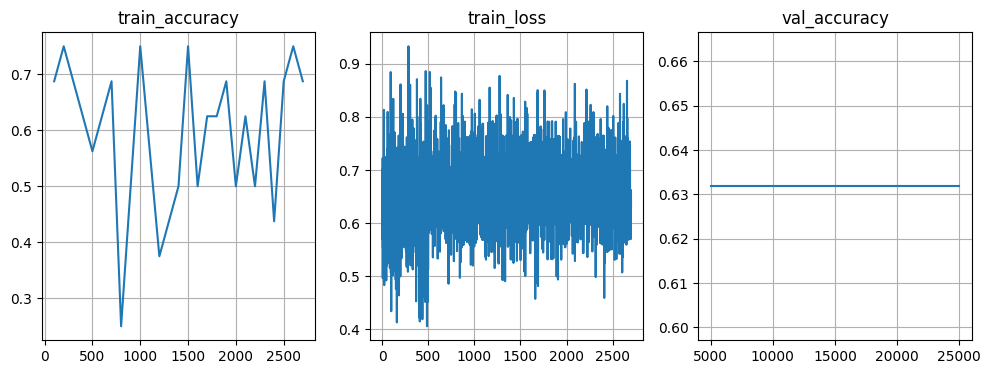

Mean loss=0.634


 12%|█▏        | 2770/22741 [52:08<6:15:58,  1.13s/it]


KeyboardInterrupt: ignored

In [36]:
metrics_data = []
metrics = {'train_loss': [], 'train_accuracy': [], 'val_accuracy': [] }
for epoch in range(2):
    print(f'Epoch number {epoch}')
    train_loss, train_accuracy, metrics = train_epoch(deberta_model, optimizer, criterion, train_loader, val_loader, scheduler, metrics)
    print(f'Training Loss: {train_loss}, train accuracy {train_accuracy}')
    val_loss, val_accuracy = val_epoch(deberta_model, criterion, val_loader)
    print(f'Validation Loss {val_loss}, validation accuracy {val_accuracy}')
    metrics_data.append(
                {
                    'train_accuracy': train_accuracy,
                    'train_loss': train_loss,
                    'val_accuracy': val_accuracy,
                    'val_loss': val_loss
                }
            )

In [ ]:
metrics_data

[{'train_accuracy': 0.8096722239628854,
  'train_loss': 0.40020095476672873,
  'val_accuracy': 0.6318327974276527,
  'val_loss': 0.6590018598137989},
 {'train_accuracy': 0.6306679199441522,
  'train_loss': 0.6591997327705911,
  'val_accuracy': 0.6318327974276527,
  'val_loss': 0.6584109027936706},
 {'train_accuracy': 0.6302336702890784,
  'train_loss': 0.6465499941586431,
  'val_accuracy': 0.6318327974276527,
  'val_loss': 0.6709750552964295}]

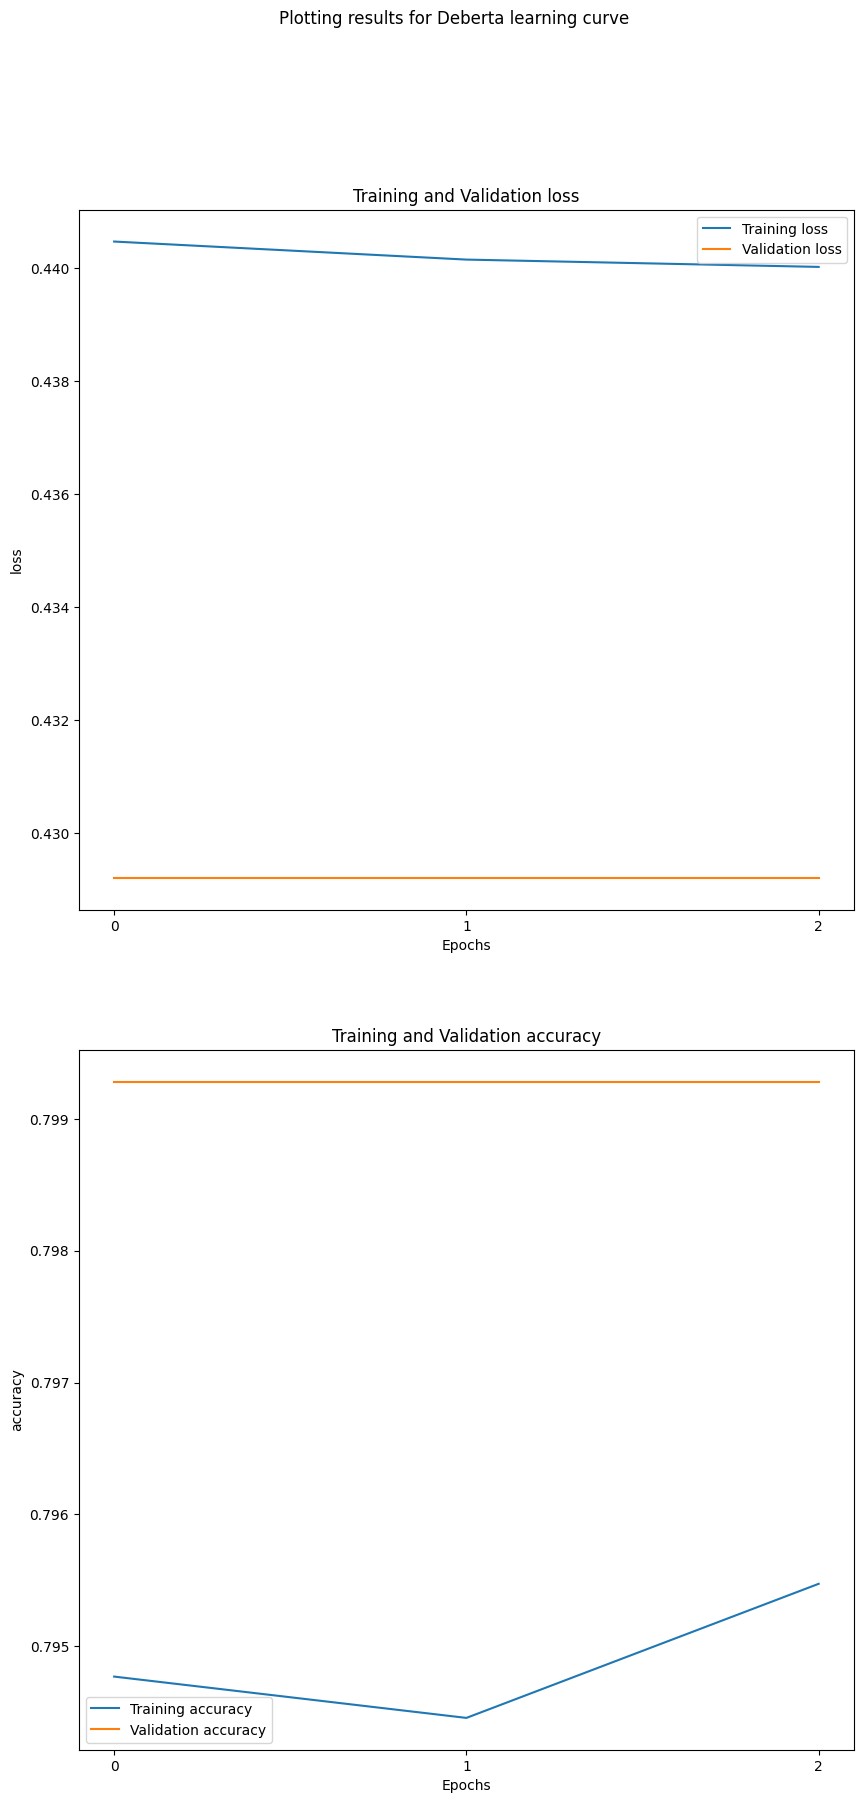

In [ ]:
plot_metric(metrics_data, 'Deberta learning curve')

In [ ]:
with open('deberta_train.pkl', 'wb') as f:
  pickle.dump(deberta_model, f)

In [ ]:
trainer = Trainer(
        model=model,
        args = TrainingArguments(do_train=True, output_dir='/'),
        tokenizer=tokenizer,
        train_dataset=train_set,
        eval_dataset=val_set
    )

In [ ]:
with open('deberta_train.pkl', 'rb') as f:
  deberta_model = pickle.load(f)

### Task 3: try the full pipeline (2 points)

Finally, it is time to use your model to find duplicate questions.
Please implement a function that takes a question and finds top-5 potential duplicates in the training set. For now, it is fine if your function is slow, as long as it yields correct results.

Showcase how your function works with at least 5 examples.

In [ ]:
questions = list(questions)

In [ ]:
def find_similar(question_str: str, tokenizer, train_questions, question_model):
  q1 = [question_str] * len(train_questions)
  tokenized = tokenizer(
        q1, train_questions,
        padding='max_length', max_length=MAX_LENGTH,
        truncation=True
  )
  dataset = Dataset.from_dict({'input_ids': tokenized['input_ids'],
                     'attention_mask': tokenized['attention_mask'],
                     'token_type_ids': tokenized['token_type_ids']})
  data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=False,
    collate_fn=transformers.default_data_collator, num_workers=2
  )
  all_probs = []
  with torch.no_grad():
    for batch in tqdm(data_loader):
      predicted = question_model(
           input_ids=batch['input_ids'].to(device),
           attention_mask=batch['attention_mask'].to(device),
           token_type_ids=batch['token_type_ids'].to(device)
      )

      probs = torch.softmax(predicted.logits, dim=1).data.cpu().numpy()
      probs_of_dup = probs[:, 1]

      all_probs.append(probs_of_dup)
    all_probs = np.concatenate((all_probs))
    ind = np.argpartition(all_probs, -5)[-5:]
    top5 = [train_questions[x] for x in ind][::-1]
    return top5


In [ ]:
top5 = find_similar('How to train a NLP model?', deberta_tokenizer, questions, deberta_model)

In [ ]:
MAX_LENGTH = 128
def preprocess_function(examples, tokenizer):
    result = tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH,
        truncation=True
    )
    result['label'] = examples['label']
    return result

__Bonus:__ for bonus points, try to find a way to run the function faster than just passing over all questions in a loop. For isntance, you can form a short-list of potential candidates using a cheaper method, and then run your tranformer on that short list. If you opted for this solution, please keep both the original implementation and the optimized one - and explain briefly what is the difference there.